# B6. Model Interpretation for "Will it Rain Tomorrow in Basel?"

This notebook builds on the improved models from B5. Here I:

1. Rebuild the tuned logistic regression model on the processed Basel data.
2. Interpret the logistic regression coefficients as feature importance.
3. Explore how changing the decision threshold affects precision, recall, and F1.
4. Train a random forest on the same features and compare its feature importance
   to the logistic regression view.

The goal is to better understand *why* the models make their predictions and
which weather features are most important for day-ahead rain forecasting.


In [1]:
# 1. Setup and Imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120


## 1. Load Processed Basel Data and Time-Aware Split

### 1.1 Read `basel_rain_features.csv` and define `X` and `y`

I reuse the preprocessed Basel-only feature table created in B4. I convert the
`DATE` column back to datetime, sort the rows chronologically, and then separate
the table into the feature matrix `X` and the target `y = RainTomorrow`.


In [ ]:
PROC_PATH = "/Users/purvigarg/Downloads/CMSE492/cmse492_project/data/processed/basel_rain_features.csv"

df = pd.read_csv(PROC_PATH)
print("Loaded processed:", df.shape)

df["DATE"] = pd.to_datetime(df["DATE"].astype(str), errors="coerce")
df = df.sort_values("DATE").reset_index(drop=True)

# define X and y
y = df["RainTomorrow"].astype(int)
feature_cols = [c for c in df.columns if c not in ["DATE", "RainTomorrow"]]
X = df[feature_cols].copy()

print("Feature columns:", feature_cols)
print("X shape:", X.shape)
print("y distribution:")
print(y.value_counts(normalize=True).rename("proportion"))

# chronological 80/20 split (same logic as B5)
n = len(df)
split_idx = int(0.8 * n)

X_train = X.iloc[:split_idx].copy()
y_train = y.iloc[:split_idx].copy()

X_test = X.iloc[split_idx:].copy()
y_test = y.iloc[split_idx:].copy()

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train dates:", df["DATE"].iloc[0], "→", df["DATE"].iloc[split_idx - 1])
print("Test dates:", df["DATE"].iloc[split_idx], "→", df["DATE"].iloc[-1])


Loaded processed: (3653, 12)
Feature columns: ['MONTH', 'RainToday', 'BASEL_pressure', 'BASEL_humidity', 'BASEL_temp_mean', 'BASEL_sunshine', 'BASEL_pressure_lag1', 'BASEL_humidity_lag1', 'BASEL_temp_mean_lag1', 'BASEL_sunshine_lag1']
X shape: (3653, 10)
y distribution:
RainTomorrow
0    0.532987
1    0.467013
Name: proportion, dtype: float64
Train shape: (2922, 10) Test shape: (731, 10)
Train dates: 2000-01-02 00:00:00 → 2008-01-01 00:00:00
Test dates: 2008-01-02 00:00:00 → 2010-01-01 00:00:00


The processed Basel dataset has 3,653 days and 10 engineered features, with a
reasonably balanced label (about 53% no-rain, 47% rain). The chronological
train–test split (train up to 2008-01-01, test from 2008-01-02 onward) means
all models are trained on the past and evaluated on a later, unseen period,
making the evaluation realistic for day-ahead forecasting.

## 2. Rebuild the Tuned Logistic Regression Model

### 2.1 Fit the final logistic regression with best hyperparameters

Based on B5, the best logistic regression used `C = 3.0` and
`class_weight = "balanced"`. Here I rebuild that model in a pipeline with
`StandardScaler`, fit it on the training set, and confirm that performance on
the test set is similar to what I saw before.


In [ ]:
logreg_clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        C=3.0,
        class_weight="balanced",
        max_iter=2000,
        solver="lbfgs"
    )),
])

logreg_clf.fit(X_train, y_train)

y_pred_logreg = logreg_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred_logreg)
prec = precision_score(y_test, y_pred_logreg)
rec = recall_score(y_test, y_pred_logreg)
f1 = f1_score(y_test, y_pred_logreg)
cm = confusion_matrix(y_test, y_pred_logreg)

print("=== Final Logistic Regression (rebuilt) ===")
print("Accuracy :", f"{acc:.3f}")
print("Precision:", f"{prec:.3f}")
print("Recall   :", f"{rec:.3f}")
print("F1       :", f"{f1:.3f}")
print("Confusion matrix:\n", cm)

print("\nClassification report:")
print(classification_report(y_test, y_pred_logreg, digits=3))


=== Final Logistic Regression (rebuilt) ===
Accuracy : 0.668
Precision: 0.640
Recall   : 0.697
F1       : 0.668
Confusion matrix:
 [[244 137]
 [106 244]]

Classification report:
              precision    recall  f1-score   support

           0      0.697     0.640     0.668       381
           1      0.640     0.697     0.668       350

    accuracy                          0.668       731
   macro avg      0.669     0.669     0.668       731
weighted avg      0.670     0.668     0.668       731



The rebuilt logistic regression with `C = 3.0` and `class_weight = "balanced"`
reaches about 0.67 test accuracy and an F1 score of 0.668 for rainy days. It
correctly identifies a large fraction of both rainy and dry days, instead of
collapsing to the majority class. Compared with the earlier simple baseline in
B3 (F1 ≈ 0.53 for Rain), this tuned model shows that a small set of engineered
features plus balanced class weights is enough to achieve substantially better
performance.


## 3. Coefficient-Based Feature Importance (Logistic Regression)

### 3.1 Extract and rank coefficients

Because the logistic regression is wrapped in a pipeline with scaling, its
coefficients tell me which *standardized* features push the model toward
predicting rain vs no rain. I extract the coefficients, compute their absolute
values, and rank features by importance.


In [14]:
logreg = logreg_clf.named_steps["logreg"]

coef = logreg.coef_[0]  # shape (n_features,)
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef": coef,
})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

coef_df


,feature,coef,abs_coef
2,BASEL_pressure,-0.927388,0.927388
1,RainToday,0.579244,0.579244
6,BASEL_pressure_lag1,0.396310,0.396310
3,BASEL_humidity,-0.164902,0.164902
7,BASEL_humidity_lag1,0.148389,0.148389
8,BASEL_temp_mean_lag1,-0.127506,0.127506
5,BASEL_sunshine,-0.119696,0.119696
4,BASEL_temp_mean,0.114905,0.114905
9,BASEL_sunshine_lag1,-0.053488,0.053488
0,MONTH,0.029930,0.029930


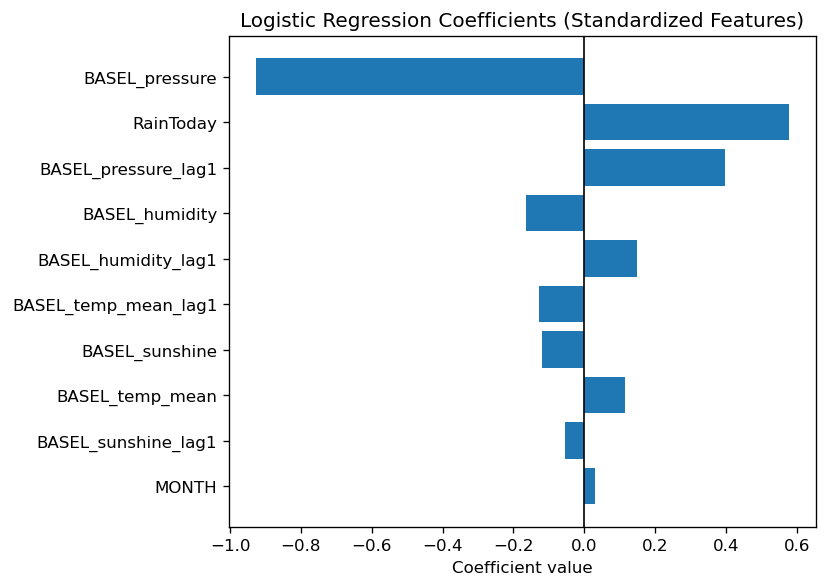

In [5]:
# 4.2 Plot coefficients by absolute value

coef_plot = coef_df.sort_values("abs_coef", ascending=True)

plt.figure(figsize=(7, 5))
plt.barh(coef_plot["feature"], coef_plot["coef"])
plt.axvline(0, color="black", linewidth=1)
plt.title("Logistic Regression Coefficients (Standardized Features)")
plt.xlabel("Coefficient value")
plt.tight_layout()
plt.show()




The coefficient plot shows that today's **pressure** is by far the strongest
driver in the model: lower pressure (a large negative coefficient) strongly
pushes the prediction toward rain. The second most influential feature is
`RainToday`, meaning that if it is raining today, the model substantially
increases the probability that it will also rain tomorrow. Lagged pressure,
humidity, temperature, and sunshine also matter, but with smaller effects. This
matches basic meteorology: low pressure and cloudy, wet conditions today are
the clearest signals of rain tomorrow, while month (seasonality) plays only a
secondary role.


## 4. Threshold and Precision–Recall Tradeoff

### 4.1 Evaluate different decision thresholds

So far the model has used the default threshold of 0.5 on the predicted rain
probability. Here I sweep several thresholds and track how precision, recall,
and F1 change for the rain class. This shows the tradeoff between catching more
rainy days and avoiding false alarms.


In [6]:
# 5.1 Compute metrics at different thresholds

y_proba = logreg_clf.predict_proba(X_test)[:, 1]

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
rows = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    rows.append({
        "threshold": t,
        "precision": precision_score(y_test, y_pred_t, zero_division=0),
        "recall": recall_score(y_test, y_pred_t),
        "f1": f1_score(y_test, y_pred_t),
    })

thresh_df = pd.DataFrame(rows)
thresh_df


,threshold,precision,recall,f1
0,0.3,0.560071,0.905714,0.692140
1,0.4,0.624161,0.797143,0.700125
2,0.5,0.640420,0.697143,0.667579
3,0.6,0.684211,0.594286,0.636086
4,0.7,0.750000,0.402857,0.524164


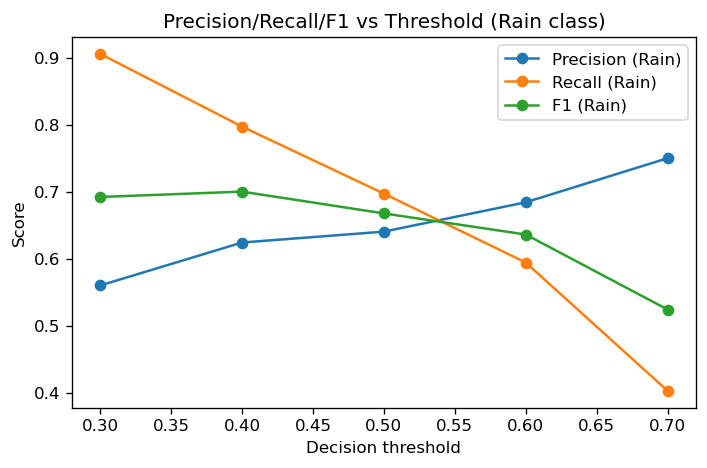

In [7]:
# 5.2 Plot precision and recall vs threshold

plt.figure(figsize=(6,4))
plt.plot(thresh_df["threshold"], thresh_df["precision"], marker="o", label="Precision (Rain)")
plt.plot(thresh_df["threshold"], thresh_df["recall"], marker="o", label="Recall (Rain)")
plt.plot(thresh_df["threshold"], thresh_df["f1"], marker="o", label="F1 (Rain)")
plt.xlabel("Decision threshold")
plt.ylabel("Score")
plt.title("Precision/Recall/F1 vs Threshold (Rain class)")
plt.legend()
plt.tight_layout()
plt.show()


The precision/recall/F1 vs threshold plot makes the tradeoff very clear:
lower thresholds (e.g., 0.3) give very high recall for rain (over 0.90) but at
the cost of many false alarms (precision ≈ 0.56), while higher thresholds
(e.g., 0.7) are very conservative (precision ≈ 0.75) but miss most rain events
(recall ≈ 0.40). The F1 score peaks around a threshold of **0.4** (≈0.70),
slightly better than the default 0.5, which suggests that if I cared purely
about F1 for rainy days I would choose a threshold near 0.4. This plot is the
evidence that there is no single “perfect” threshold: the right choice depends
on whether we want to prioritize catching rain (recall) or avoiding false
alarms (precision).


## 5. Random Forest Feature Importance vs Logistic Coefficients

### 5.1 Train a random forest and compare importance

To cross-check the logistic regression view, I train a random forest on the same
training data and compute its feature importances. If both models highlight the
same variables, that increases confidence that those features are genuinely
informative, not just artifacts of a particular model.


In [15]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=0,
    n_jobs=-1,
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
print("Random Forest accuracy:", f"{acc_rf:.3f}", "F1 (Rain):", f"{f1_rf:.3f}")

rf_importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
rf_importances


Random Forest accuracy: 0.670 F1 (Rain): 0.656


BASEL_pressure          0.174164
BASEL_pressure_lag1     0.129110
BASEL_temp_mean         0.104143
BASEL_temp_mean_lag1    0.101512
BASEL_sunshine          0.094483
RainToday               0.091315
BASEL_humidity_lag1     0.086223
BASEL_sunshine_lag1     0.084502
BASEL_humidity          0.083258
MONTH                   0.051289
dtype: float64

In [16]:


merged = pd.DataFrame({
    "logreg_abs_coef": coef_df.set_index("feature")["abs_coef"],
    "rf_importance": rf_importances,
})
merged = merged.sort_values("rf_importance", ascending=False)
merged


,logreg_abs_coef,rf_importance
BASEL_pressure,0.927388,0.174164
BASEL_pressure_lag1,0.396310,0.129110
BASEL_temp_mean,0.114905,0.104143
BASEL_temp_mean_lag1,0.127506,0.101512
BASEL_sunshine,0.119696,0.094483
RainToday,0.579244,0.091315
BASEL_humidity_lag1,0.148389,0.086223
BASEL_sunshine_lag1,0.053488,0.084502
BASEL_humidity,0.164902,0.083258
MONTH,0.029930,0.051289




The random forest achieves almost the same accuracy and F1 as logistic
regression and ranks the features in a very similar way: current and lagged
**pressure** are most important, followed by temperature, sunshine, humidity,
and `RainToday`. Comparing random forest importance to the logistic regression
coefficients shows that both a linear model and a nonlinear ensemble see the
same core variables as most informative. This agreement suggests that the
model’s story about “what causes rain tomorrow” is not an artifact of one
particular algorithm but a stable pattern in the data.


##  Conclusion 
This notebook explains *why* the tuned logistic regression works for Basel
rain/no-rain prediction. Using standardized coefficients, I showed that low
pressure, recent rain (`RainToday`), and recent temperature/sunshine patterns
are the dominant signals the model uses to predict rain tomorrow. The threshold
analysis demonstrated the classic precision–recall tradeoff and showed that a
threshold around 0.4–0.5 gives the best F1 for rainy days, while higher
thresholds sacrifice recall for fewer false alarms.

Random forest feature importance largely agrees with the logistic regression
view, highlighting the same variables as most important. Together, these plots
and metrics support a clear narrative for the final report: a small,
physics-guided feature set and a tuned, interpretable logistic regression are
able to capture most of the useful station-level signal in this dataset, and
their behavior is consistent with standard meteorological intuition.
